# PMLDL. Week 13. CLIP implementation

[Competition link](https://www.kaggle.com/t/3aef8d87389c4207ac40342cf1d09b14)

The task of this competition is to train a multimodal model, i.e. a model that has inputs from various domains. Particulary, you're going to train CLIP model on a subset of [Flickr30k](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) dataset. Flickr consists of images with different text descriptions (5 per each image), so by training the CLIP model with CNN as image encoder and some BERT as text encoder, you'll be able to match images with their descriptions.

We'll use some new for us packages:

- *timm* (Py**T**orch **Im**age **M**odels) - a collection of image models, layers, data-loaders etc. that aim to pull together Pytorch models with Huggingface interface.
- *albumentations* - package for advanced data augmentation.

In [97]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations

import torch
from torch import nn
import torch.nn.functional as F
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(42)

In [ ]:
# Path to .csv file with image captions in flickr
labels_path = "/kaggle/input/pmldl-week-13-clip/results_train.csv"
# Path to folder with images
image_path = "/kaggle/input/pmldl-week-13-clip/flickr10k_train/flickr10k_train"


In [99]:
# Each image in dataset has 5 captions
# id columns stands for a each image
df = pd.read_csv(labels_path)
df.head(20)

,image,caption_number,caption,id
0,1000268201.jpg,0,A child in a pink dress is climbing up a set o...,0
1,1000268201.jpg,1,A little girl in a pink dress going into a woo...,0
2,1000268201.jpg,2,A little girl climbing the stairs to her playh...,0
3,1000268201.jpg,3,A little girl climbing into a wooden playhouse,0
4,1000268201.jpg,4,A girl going into a wooden building .,0
5,1000523639.jpg,0,Two people in the photo are playing the guitar...,1
6,1000523639.jpg,1,A man in green holds a guitar while the other ...,1
7,1000523639.jpg,2,A man is fixing the guitar players costume .,1
8,1000523639.jpg,3,a guy stitching up another man 's coat .,1
9,1000523639.jpg,4,the two boys playing guitar,1


## 1. Dataset

Define a structure of dataset for convenient working both with images and descriptions from Flickr

In [ ]:
# Data augmentation
def get_transforms(mode="train"):
    img_size = 224
    if mode == "train":
        return albumentations.Compose(
            [
                # You can add additional augmentations
                albumentations.Resize(img_size, img_size),
                albumentations.Normalize(max_pixel_value=255.0),
            ]
        )
    else:
        return albumentations.Compose(
            [
                albumentations.Resize(img_size, img_size),
                albumentations.Normalize(max_pixel_value=255.0),
            ]
        )
        

# Load and formate the image that stores by img_path
# with transform app_transforms (one of the get_transforms() augmentations)
def preprocess_image(img_path, app_transforms):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = app_transforms(image=image)['image']
    return torch.tensor(image).permute(2, 0, 1).float()

class FlickrDataset(torch.utils.data.Dataset):
    # image_filenames - pd.Series with path to images 
    # captions - pd.Series with descriptions of the images
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(list(captions), padding=True, truncation=True, max_length=200)
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        
        item['image'] = preprocess_image(f"{image_path}/{self.image_filenames[idx]}", self.transforms)
        item['caption'] = self.captions[idx]
        return item
        
    def __len__(self):
        return len(self.captions)

### 2.1 Image encoder

*timm* allows to treat CNNs like transformers from HuggingFace. For example, *timm.create_model()* loads a model named by the first string parameter in the function, in the way as *transformers.AutoModel()*. While the authors of original CLIP didn't utilize pretrain weight, we'll load both CNN and BERT models due to lack of data and computation time.

**Choose some CNN you prefer**

In [101]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name: str = "resnet50"):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        # Return not classes from ImageNet, but activation from penultimate layer
        return self.model(x)



### 2.2 Text encoder

**Choose some BERT you prefer**

In [102]:
from transformers import AutoModel, AutoTokenizer


class TextEncoder(nn.Module):
    def __init__(self, model_name: str = "bert-base-uncased"):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        for p in self.model.parameters():
            p.requires_grad = True
        # We are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]



### 2.3 Projection head

After the encoders do their job, you should apply a nonlinear projection on the embeddings. By that, you get text and image embeddings in the same dimension space

In [103]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

### 2.5 Combine everything into a  CLIP model

Calculate loss in CLIP by the following pseudocode:
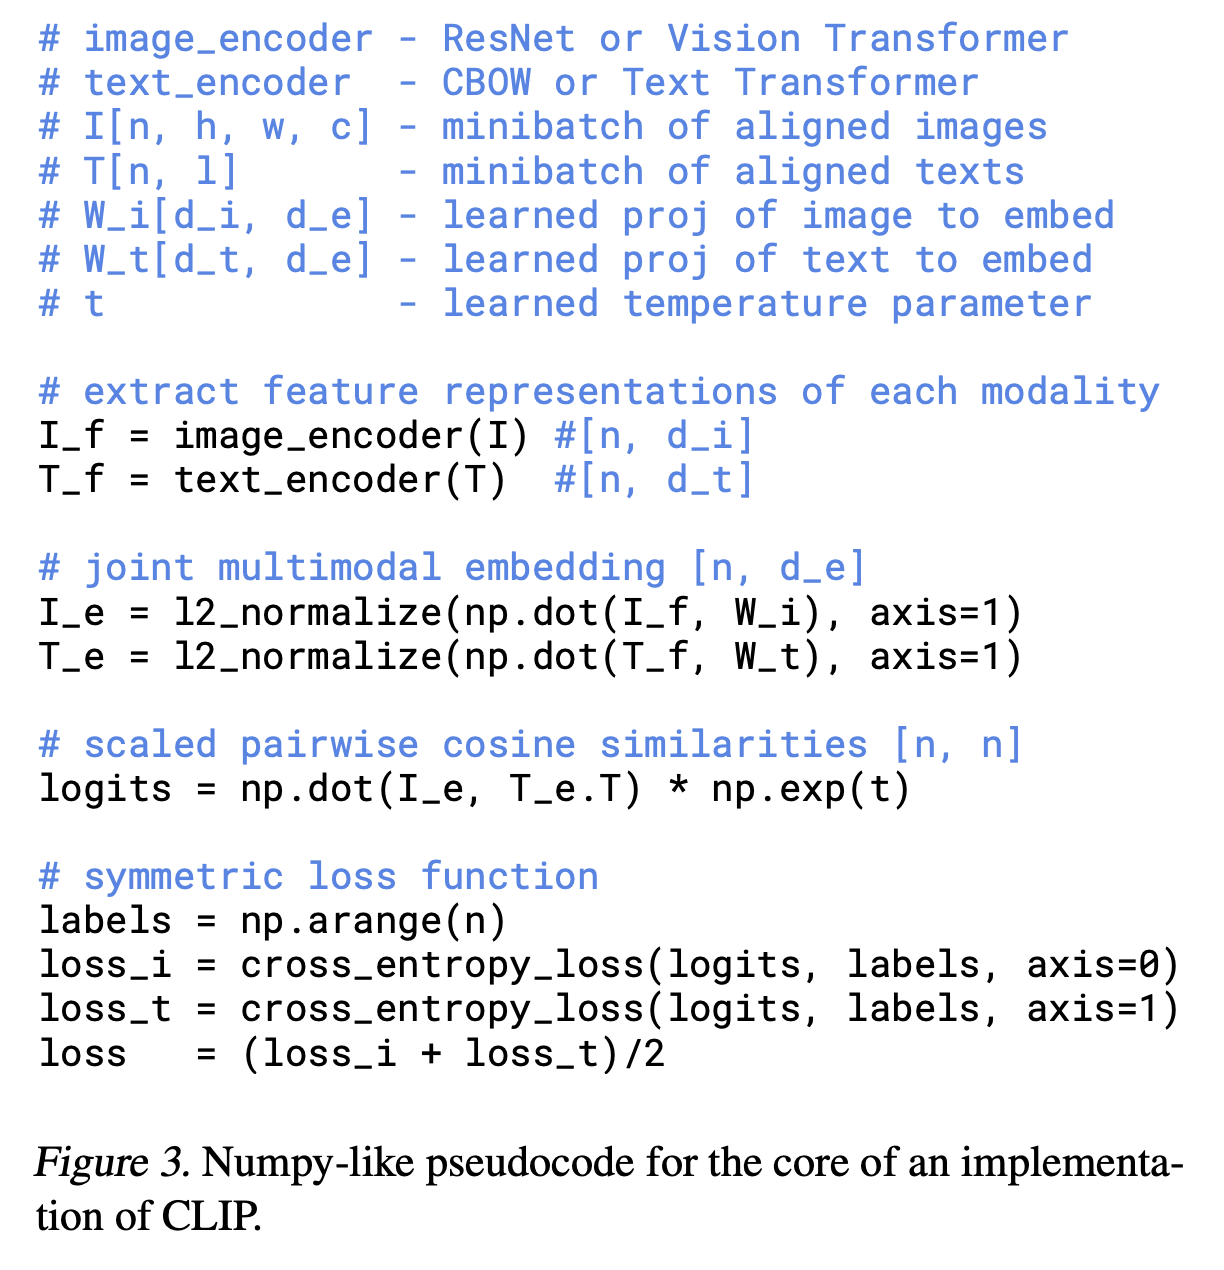

You don't need to use numpy,
Please refer to the [paper](https://arxiv.org/abs/2103.00020) for more information

In [104]:
class CLIP(nn.Module):
    def __init__(
        self,
        image_model_name,
        text_model_name,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder(model_name=image_model_name)
        self.text_encoder = TextEncoder(model_name=text_model_name)
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the loss
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)

        # Symmetric loss function
        logits = text_embeddings @ image_embeddings.T / self.temperature
        targets = torch.eye(logits.shape[0], device=logits.device)
        texts_loss = cross_entropy(logits, targets, reduction="none")
        images_loss = cross_entropy(logits.T, targets, reduction="none")
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()



## 3. Training

### 3.1 Define some training functions

In [105]:
def build_loaders(dataframe, tokenizer, mode):
    transform = get_transforms(mode=mode)
    dataset = FlickrDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transform,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [120]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_epoch(model, train_loader, optimizer):
    model.train()
    
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_object.set_postfix(train_loss=loss.item(), lr=get_lr(optimizer))


def valid_epoch(model, valid_loader):
    model.eval()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        tqdm_object.set_postfix(valid_loss=loss.item())

### 3.2 Hyperparameters setting and train&validation split

In [121]:
head_lr = 1e-3
image_encoder_lr = 1e-4
text_encoder_lr = 1e-5
weight_decay = 1e-3
epochs = 3

In [ ]:
max_id = df['id'].max() + 1
image_ids = np.arange(0, max_id)

valid_ids = np.random.choice(image_ids, size=int(0.2 * len(image_ids)), replace=False)
train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
valid_df = df[df["id"].isin(valid_ids)].reset_index(drop=True)

### 3.3 Running train

In [122]:
# Write your code here
text_model = 'bert-base-uncased'
image_model = 'resnet50'
tokenizer = AutoTokenizer.from_pretrained(text_model)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


model = CLIP(text_model_name=text_model, image_model_name=image_model).to(device)
params = [
    {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
    {"params": itertools.chain(model.image_projection.parameters(),
                               model.text_projection.parameters()),
                            "lr": head_lr, "weight_decay": weight_decay}
]
optimizer = torch.optim.AdamW(params)


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch(model, train_loader, optimizer)
    with torch.no_grad():
        valid_epoch(model, valid_loader)



Epoch 1/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/313 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Epoch 2/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/313 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

Epoch 3/3


  0%|          | 0/1250 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/313 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environm

## 4. Submission

We measure the quality of the CLIP model by its ability to match text descriptions with images. In test dataset, you're given **labels.csv** file with the descriptions (in the same manner as in train set), and folder with images.

You need to calculate embeddings of both images and descriptions, measure cosine similarity between embeddings and return top 7 image file names per each description. Note that every five desctiptions correspond to one image, and a nice trained model returns about the same range of images for such descriptions. 

When doing competition evaluation, for each image we take best Reciprocal Rank (RR) alongside its five desctiption. For example, you need to retrive an image with name **cor_img.jpg** and have the predictions:

1. [wrong_img1.jpg, wrong_img2.jpg, wrong_img3.jpg,  *cor_img.jpg*, wrong_img4.jpg, wrong_img5.jpg, wrong_img6.jpg]
2. [wrong_img3.jpg, wrong_img1.jpg, wrong_img12.jpg,  wrong_img5.jpg, *cor_img.jpg*, wrong_img6.jpg, wrong_img10.jpg]
3. [**cor_img.jpg**, wrong_img2.jpg, wrong_img20.jpg, wrong_img6.jpg, wrong_img4.jpg, wrong_img1.jpg, wrong_img10.jpg]
4. [wrong_img2.jpg, wrong_img1.jpg, wrong_img12.jpg,  *cor_img.jpg*, wrong_img10.jpg, wrong_img5.jpg, wrong_img6.jpg]
5. [wrong_img1.jpg, wrong_img2.jpg, wrong_img3.jpg,  wrong_img10.jpg, wrong_img4.jpg, wrong_img5.jpg, wrong_img6.jpg]

For the 3rd desctiption, **cor_img.jpg** stays at the top, thus we consider RR for this sample as 1.

In [ ]:
import os

def get_test_filepath():
    test_path = "/kaggle/input/pmldl-week-13-clip/flickr10k_test/flickr10k_test"
    file_paths = []
    for filename in os.listdir(test_path):
        f = os.path.join(test_path, filename)
        if '.jpg' in f:
            file_paths.append(f)
    return file_paths

def get_test_embeddings(model, file_paths):
    valid_image_embeddings = []
    transform = get_transforms(mode='valid')
    with torch.no_grad():
        for file_path in tqdm(file_paths):
            image_features = model.image_encoder(preprocess_image(file_path, transform).unsqueeze(0).to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)


def find_matches(model, image_embeddings,tokenizer, query, image_filenames, n):
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
    similarity = text_embeddings @ image_embeddings.T
    _, indices = similarity[0].topk(n)
    # Indices stands for top n indices in similarity vector
    matches = [image_filenames[idx].split("/")[-1] for idx in indices]
    return matches



In [ ]:
test_df = pd.read_csv("/kaggle/input/pmldl-week-13-clip/labels.csv")

In [125]:
file_paths = get_test_filepath()
image_embeddings = get_test_embeddings(model, file_paths)

100%|██████████| 200/200 [00:03<00:00, 66.42it/s]


In [129]:
submission_df = pd.DataFrame(columns=['ID', *(range(7))])
submission_df['image_id'] = test_df.id
submission_df['ID'] = test_df.index

for ind, row in test_df.iterrows(): 
    predicted_path = find_matches(model, image_embeddings, tokenizer, 
                                  row['caption'],file_paths, 7)
    for i in range(7):
        submission_df.at[ind, i] = predicted_path[i]
    

In [95]:
# Some samples from my solution
submission_df.head(20)

,ID,0,1,2,3,4,5,6
0,0,116457850.jpg,2889346148.jpg,2981162237.jpg,2441818043.jpg,753285176.jpg,4800121810.jpg,2359784186.jpg
1,0,116457850.jpg,2889346148.jpg,2981162237.jpg,2359784186.jpg,2441818043.jpg,3341628972.jpg,6229825733.jpg
2,0,570996053.jpg,550119995.jpg,2422637172.jpg,2981162237.jpg,6229825733.jpg,116457850.jpg,2528117348.jpg
3,0,116457850.jpg,2889346148.jpg,2981162237.jpg,550119995.jpg,6229825733.jpg,4800121810.jpg,2441818043.jpg
4,0,116457850.jpg,1873704867.jpg,2889346148.jpg,550119995.jpg,6229825733.jpg,570996053.jpg,4800121810.jpg
5,1,294839797.jpg,3545652636.jpg,123101580.jpg,2353119813.jpg,6950137939.jpg,2423856014.jpg,4680828876.jpg
6,1,3545652636.jpg,294839797.jpg,123101580.jpg,2353119813.jpg,2423856014.jpg,6950137939.jpg,6869365418.jpg
7,1,294839797.jpg,2353119813.jpg,123101580.jpg,3545652636.jpg,6950137939.jpg,2423856014.jpg,2936693681.jpg
8,1,294839797.jpg,2353119813.jpg,123101580.jpg,3545652636.jpg,6950137939.jpg,4680828876.jpg,2423856014.jpg
9,1,123101580.jpg,294839797.jpg,2353119813.jpg,6950137939.jpg,3545652636.jpg,2527829321.jpg,4680828876.jpg


In [130]:
submission_df.to_csv("submission.csv", index=False)